Import python libraries

In [248]:
import os
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

These are the set of functions that are going to be used in the CV pipeline for obtaining the lane lines

In [249]:
def get_calib_params():
    """
    This function loads and returns the calibration parameters obtained
    in calib_params script.
    Args:
        None
    Returns:
        mtx(numpy.array): Camera matrix
        dist(numpy.array): Distortion coefficients
    """
    with open('calib_params.pickle', 'rb') as handle:
        calib_params = pickle.load(handle)

    mtx = calib_params["mtx"]
    dist = calib_params["dist"]
    return mtx, dist

# Thresholding
def get_binary_image(image, s_thresh=(170, 255), mag_thresh=(50, 200), dir_thresh=(0, np.pi/2)):
    """
    This function applies different thresholding method to obtain a binary image.
    Args:
        img(numpy.array): 3-channel image
        s_thresh(tuple): low and high threshold for channel S from HSV color space
        sx_thresh(tuple): low and high threshold for sobel kernel convolution in x dimension
    Returns:
        combined_binary(numpy.array): 1-channel image
    """
    img = np.copy(image)
    # Gradient thresholding
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobelx = np.absolute(sobelx) 
    abs_sobely = np.absolute(sobely)
    # Threshold by magnitud
    mag = np.sqrt(np.square(sobelx)+np.square(sobely))
    scaled_mag = np.uint8(255*mag/np.max(mag))
    mag_binary = np.zeros_like(scaled_mag)
    mag_binary[(scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])] = 1
    """
    # Threshold by direction
    direction = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction >= dir_thresh[0]) & (direction <= dir_thresh[1])] = 1
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(dir_binary, cv2.MORPH_OPEN, kernel)
    """
    # Threshold color channel
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine the binary thresholds
    combined_binary = np.zeros_like(mag_binary)
    #combined_binary[(s_binary == 1) | (mag_binary == 1) | (opening == 1)] = 1
    combined_binary[(s_binary == 1) | (mag_binary == 1)] = 1
    return combined_binary

def warp_image(image):
    """
    This function warps the binary image in order to obtain the egle eye point of view.
    Args:
        img(numpy.array): 1-channel image
    Returns:
        warped(numpy.array): 1-channel warped image
    """
    img = np.copy(image)
    offset_x = 100 # offset for dst points
    offset_y = 50 # offset for dst points
    roi_offset_up_y = 100
    roi_offset_up_x = 75
    roi_offset_down_x = 125
    # Grab the image shape
    h, w = img.shape
    # Define source points
    src = np.float32([[int(w/2)-roi_offset_up_x,int(h/2)+roi_offset_up_y],
                      [int(w/2)+roi_offset_up_x,int(h/2)+roi_offset_up_y], 
                         [w-roi_offset_down_x,h], [roi_offset_down_x,h]])
    # Define destination points
    dst = np.float32([[offset_x, offset_y], [w-offset_x, offset_y], [w-offset_x, h-offset_y], 
                                 [offset_x, h-offset_y]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (w,h))
    return warped

def img_processing(img):
    """
    This function calls a set of functions in order to follow the defined pipeline.
    Args:
        img(numpy.array): 1-channel image
    Returns:
        warped(numpy.array): 1-channel warped image
    """
    # Undistore image
    mtx, dist = get_calib_params() # Get calibration parameters
    undist = cv2.undistort(img, mtx, dist, None, mtx) # Undistore the image
    #  Get the binary image 
    binary_image = get_binary_image(undist)
    # Transform image to eagle view
    warped = warp_image(binary_image)
    return warped

def find_lane_pixels(binary_warped):
    """
    This function applies an sliding window approach to determine which pixels 
    will define the different lane lines.
    Args:
        img(numpy.array): 1-channel image
    Returns:
        leftx(list): List of x coordinates of the left lane line
        lefty(list): List of y coordinates of the left lane line
        rightx(list): List of x coordinates of the right lane line
        righty(list): List of y coordinates of the right lane line
        out_img(numpy.array): Image that shows the pixels that correspond to both of the lines
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        #Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    """
    This function fits and visualizes a second order polynomial to the returns obtained by 
    the find_lane_pixels function.
    Args:
        binary_warped(numpy.array): 1-channel image
    Returns:
        out_img(numpy.array): Image that shows the fitted curves
    """
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    """
    This function fits second order polynomial to the returns obtained by 
    the find_lane_pixels function and creates a discrete set of point of that 
    curve projected into the image.
    Args:
        img_shape(tuple): Height and width of the image being used
    Returns:
        left_fit(numpy.array): Second order polynomial for the left curve
        right_fit(numpy.array): Second order polynomial for the right curve
        left_fitx(): Discrete values corresponding to the projection of 
            the left curve on the x axis
        right_fitx():Discrete values corresponding to the projection of 
            the right curve on the x axis
        ploty(): Discrete values corresponding to the projection of the 
            curve on the y axis
        out_img(numpy.array): Image that shows the fitted curves
    """
    # Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    """
    This function finds the pixels that correspond to the left and 
    right lines using an intial set of curves, fits new polynomials
    to those pixels and returns the new equations and discrete curves.
    Args:
        binary_warped(numpy.array): 1-channel image
        left_fit(numpy.array): Second order polynomial for the left curve
        right_fit(numpy.array): Second order polynomial for the right curve
    Returns:
        left_fit(numpy.array): Second order polynomial for the new left curve
        right_fit(numpy.array): Second order polynomial for the new right curve
        left_fitx(): Discrete values corresponding to the projection of the new 
            left curve on the x axis
        right_fitx():Discrete values corresponding to the projection of the 
            right curve on the x axis
        ploty(): Discrete values corresponding to the projection of the curve 
            on the y axis
        out_img(numpy.array): Image that shows the fitted curves
    """
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty, result

def measure_curvature_real(left_fit_cr, right_fit_cr, ploty):

    """
    Calculates the curvature of polynomial functions in meters and the position 
    of the center between the 2 curvatures in pixels.
    Args:
        left_fit_cr(numpy.array): Second order polynomial for the left curve
        right_fit_cr(numpy.array): Second order polynomial for the right curve
        ploty(): Discrete values corresponding to the projection of the curve 
            on the y axis
    Returns:
        left_curverad: Radius of curvature of the left curve in meters
        right_curverad: Radius of curvature of the right curve in meters
        curv_center: Center of the 2 curves in pixels
    """
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1+(2*left_fit_cr[0]*y_eval*ym_per_pix+left_fit_cr[1])**2)**(1.5))/np.abs(2*left_fit_cr[0])
    right_curverad = ((1+(2*right_fit_cr[0]*y_eval*ym_per_pix+right_fit_cr[1])**2)**(1.5))/np.abs(2*right_fit_cr[0])
    
    left_bottomx = left_fit_cr[0]*y_eval**2 + left_fit_cr[1]*y_eval + left_fit_cr[2]
    right_bottomx = right_fit_cr[0]*y_eval**2 + right_fit_cr[1]*y_eval + right_fit_cr[2]
    curv_center = (left_bottomx + right_bottomx)/2
    return left_curverad, right_curverad, curv_center

def unwarp_image(image):
    """
    This function unwarps the binary image in order to obtain the original projection.
    Args:
        image(numpy.array): 1-channel warpedimage
    Returns:
        unwarped(numpy.array): 1-channel unwarped image
    """
    img = np.copy(image)
    offset_x = 100 # offset for dst points
    offset_y = 50 # offset for dst points
    roi_offset_up_y = 100
    roi_offset_up_x = 75
    roi_offset_down_x = 125
    # Grab the image shape
    h, w, _ = img.shape
    # Define source points
    src = np.float32([[int(w/2)-roi_offset_up_x,int(h/2)+roi_offset_up_y],
                      [int(w/2)+roi_offset_up_x,int(h/2)+roi_offset_up_y], 
                         [w-roi_offset_down_x,h], [roi_offset_down_x,h]])
    # Define destination points
    dst = np.float32([[offset_x, offset_y], [w-offset_x, offset_y], [w-offset_x, h-offset_y], 
                                 [offset_x, h-offset_y]])
    # Given src and dst points, calculate the perspective transform matrix
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    unwarped = cv2.warpPerspective(img, Minv, (w,h))
    return unwarped

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def draw_lines(warped, undist, left_fitx, right_fitx, ploty):
    """
    This function draws the obtained curves onto the original undistored image
    Args:
        warped(numpy.array): 1-channel warped image (only used for obtaining the 
            image size)
        undist(numpy.array): Original undistored image
        left_fitx(): Discrete values corresponding to the projection of the 
            left curve on the x axis
        right_fitx():Discrete values corresponding to the projection of the 
            right curve on the x axis
        ploty(): Discrete values corresponding to the projection of the curve 
            on the y axis
    Returns:
        result(numpy.array): Original undistred image with the lines drawn
    """
    # Inverse warping Matrix
    offset_x = 100 # offset for dst points
    offset_y = 50 # offset for dst points
    roi_offset_up_y = 100
    roi_offset_up_x = 75
    roi_offset_down_x = 125
    # Grab the image shape
    h, w = warped.shape
    # Define source points
    src = np.float32([[int(w/2)-roi_offset_up_x,int(h/2)+roi_offset_up_y],
                      [int(w/2)+roi_offset_up_x,int(h/2)+roi_offset_up_y], 
                         [w-roi_offset_down_x,h], [roi_offset_down_x,h]])
    # Define destination points
    dst = np.float32([[offset_x, offset_y], [w-offset_x, offset_y], [w-offset_x, h-offset_y], 
                                 [offset_x, h-offset_y]])
    # Given src and dst points, calculate the perspective transform matrix
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

def display_curv(image, left_curverad, right_curverad, curv_center):
    """
    Displays the ovtained results over the final image and calculates the offset
    from the center
    Args:
        image(numpy.array): 
        left_curverad: Left radius of curvature
        right_curverad: Right radius of curvature
        curv_center: Center of the 2 curves in pixels
    Returns:
        img(numpy.array): Image with the values displayed
    """
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    h, w, _ = image.shape
    img = np.copy(image)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    # Display left curvature radius
    cv2.putText(img,'Left rad: '+str(round(left_curverad,2)),
                (100,100), font, 2,(255,0,255),4,cv2.LINE_AA)
    # Display right curvature radius
    cv2.putText(img,'Right rad: '+str(round(right_curverad,2)),
                (100,200), font, 2,(255,0,255),4,cv2.LINE_AA)
    # Display distance from center
    offset = (curv_center - w/2)*xm_per_pix
    cv2.putText(img,'Offset: '+str(round(offset,2))+'m',
                (100,300), font, 2,(255,0,255),4,cv2.LINE_AA)  
    return img
    

Load test images

In [250]:
# Load dataset images
path = 'test_images'
img_files = [(os.path.join(root, name))
    for root, dirs, files in os.walk(path)
    for name in files if name.endswith((".jpg"))]

Pipeline!!!

True

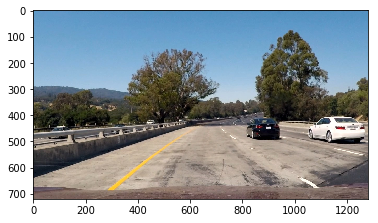

In [251]:
# Load image
img = cv2.imread(img_files[3])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
cv2.imwrite("screenshots/original.jpg", img)

True

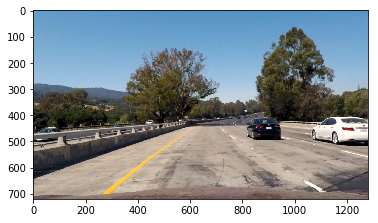

In [252]:
# Undistore image
mtx, dist = get_calib_params() # Get calibration parameters
undist = cv2.undistort(img, mtx, dist, None, mtx) # Undistore the image
# Display undistored image
plt.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
cv2.imwrite("screenshots/undist.jpg", undist)

Theshold the image

True

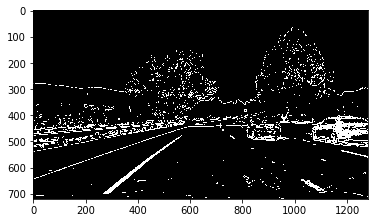

In [253]:
binary_image = get_binary_image(undist)
plt.imshow(binary_image, cmap='Greys_r')
cv2.imwrite("screenshots/thresholded.png", binary_image.astype('uint8') * 255)

True

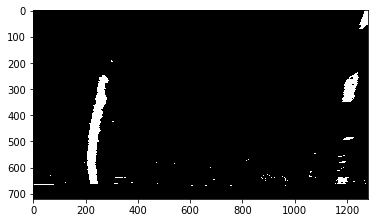

In [254]:
warped = warp_image(binary_image)
plt.imshow(warped, cmap='Greys_r')
cv2.imwrite("screenshots/warped.png", warped.astype('uint8') * 255)

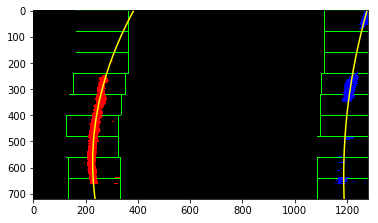

In [255]:
binary_warped = img_processing(img)
plt.imshow(binary_warped, cmap='Greys_r')
out_img = fit_polynomial(binary_warped)
cv2.imwrite("screenshots/sliding_window.png", out_img)
plt.imshow(out_img)

[  4.66225145e-04  -5.40460575e-01   3.83923402e+02] [  2.21517264e-04  -2.80981407e-01   1.27613970e+03]
[  4.61917035e-04  -5.37019086e-01   3.83271289e+02] [  2.21517264e-04  -2.80981407e-01   1.27613970e+03]


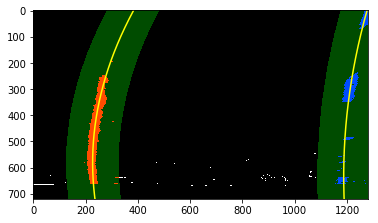

In [256]:
leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
print(left_fit, right_fit)
# The idea here is to use the previous fit as initial point but giving a new binary_warped
left_fit, right_fit, left_fitx, right_fitx, ploty, result = search_around_poly(binary_warped, left_fit, right_fit)
cv2.imwrite("screenshots/search_polygon.png", result)
plt.imshow(result)
print(left_fit, right_fit)

Measure the curvature radius

In [257]:
left_curverad, right_curverad, curv_center = measure_curvature_real(left_fit, right_fit, ploty)
print(left_curverad, right_curverad, curv_center)

1529.91391452 2504.10669952 712.288754987


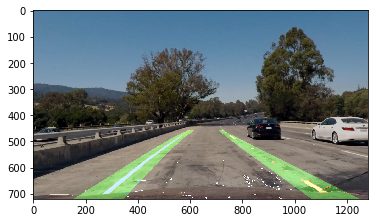

In [258]:
unwarped_img = unwarp_image(result)
unwarped_img_undist = weighted_img(unwarped_img, undist, α=0.8, β=1., γ=0.)
cv2.imwrite("screenshots/unwarped_img_undist.jpg", unwarped_img_undist)
plt.imshow(cv2.cvtColor(unwarped_img_undist, cv2.COLOR_BGR2RGB))

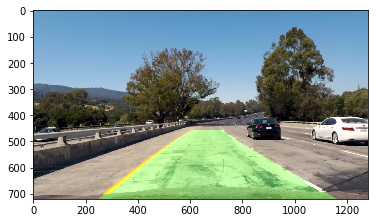

In [259]:
undist_lines = draw_lines(binary_warped, undist, left_fitx, right_fitx, ploty)
cv2.imwrite("screenshots/undist_lines.jpg", undist_lines)
plt.imshow(cv2.cvtColor(undist_lines, cv2.COLOR_BGR2RGB))

Displaying the radius

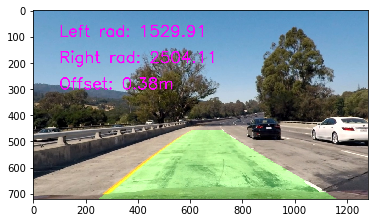

In [260]:
undist_lines_rads = display_curv(undist_lines, left_curverad, right_curverad, curv_center)
cv2.imwrite("screenshots/undist_lines_rads.jpg", undist_lines_rads)
plt.imshow(cv2.cvtColor(undist_lines_rads, cv2.COLOR_BGR2RGB))